In [1]:
devtools::install_github("philippmuench/HaplotypeDeconstructor")

cli         (3.2.0   -> 3.3.0  ) [CRAN]
tibble      (3.1.6   -> 3.1.7  ) [CRAN]
scales      (1.1.1   -> 1.2.0  ) [CRAN]
registry    (NA      -> 0.5-1  ) [CRAN]
Rtsne       (0.15    -> 0.16   ) [CRAN]
V8          (NA      -> 4.1.0  ) [CRAN]
dplyr       (1.0.8   -> 1.0.9  ) [CRAN]
BiocManager (1.30.16 -> 1.30.17) [CRAN]
ggplot2     (3.3.5   -> 3.3.6  ) [CRAN]
gridBase    (NA      -> 0.4-7  ) [CRAN]
rngtools    (NA      -> 1.5.2  ) [CRAN]
pkgmaker    (NA      -> 0.32.2 ) [CRAN]
randomcoloR (NA      -> 1.1.0.1) [CRAN]
NMF         (NA      -> 0.24.0 ) [CRAN]


Skipping 2 packages not available: Biobase, ComplexHeatmap

Installing 14 packages: cli, tibble, scales, registry, Rtsne, V8, dplyr, BiocManager, ggplot2, gridBase, rngtools, pkgmaker, randomcoloR, NMF

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



✔  checking for file ‘/tmp/Rtmp81BIlq/remotes256063230c3d72/philippmuench-HaplotypeDeconstructor-f8b5b79/DESCRIPTION’
─  preparing ‘HaplotypeDeconstructor’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
     NB: this package now depends on R (>= 3.5.0)
     serialize/load version 3 cannot be read in older versions of R.
     File(s) containing such objects:
       ‘HaplotypeDeconstructor/data-raw/omm_ab.rds’
       ‘HaplotypeDeconstructor/data-raw/omm_claudia_new.rds’
       ‘HaplotypeDeconstructor/data-raw/reseq.rds’
─  building ‘HaplotypeDeconstructor_0.1.0.tar.gz’
   


In [5]:
library(HaplotypeDeconstructor)
library(circlize)
library(tidyr)
library(data.table)
library(ComplexHeatmap)
library(circlize)
library(dplyr)
library(plyr)
library(HaplotypeDeconstructor)
library(vcfR)
library(NMF)
library(ggplot2)
library(fastICA)
library(matrixStats)
library(OligoMMR2)


Attaching package: ‘HaplotypeDeconstructor’


The following object is masked _by_ ‘.GlobalEnv’:

    omm


circlize version 0.4.14
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can dir

In [6]:
wgs_data <- readRDS("../../datasets/omm_wgs_imputed_wide_filtered.rds")
unique(wgs_data$chr)

[1] "Akkermansia_muciniphila_YL44"        "Bacteroides_caecimuris_I48"         
[3] "Blautia_coccoides_YL58"              "Clostridium_innocuum_I46"           
[5] "Enterocloster_clostridioformis_YL32" "Flavonifractor_plautii_YL31"        
[7] "Limosilactobacillus_reuteri_I49"     "Muribaculum_intestinale_YL27"       
[9] "Turicimonas_muris_YL45"

## Akkermansia_muciniphila_YL44

In [31]:
bug <- "Akkermansia_muciniphila_YL44"
dat <- wgs_data[which(wgs_data$chr == bug), ]
dim(dat)
nrow(dat)
omm <- dat[, grep("16", colnames(dat), invert = F)]
annot  <- dat[, grep("16", colnames(dat), invert = T)]
omm[is.na(omm)] <- 0
rownames(omm) <- paste0(annot$chr, "-",annot$POS, "-", annot$REF,"-", annot$ALT)
omm <- data.matrix(omm)
omm <- omm[,colSds(omm) > 0]
gof <- assessNumberHaplotyes(omm, 2:10)
gof_agg <- aggregate(data = gof, ExplainedVariance ~NumberHaplotyes, FUN = mean)
num <- min(gof_agg[which(gof_agg$ExplainedVariance > 0.8),]$NumberHaplotyes)

[1]  26 135

[1] 26

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



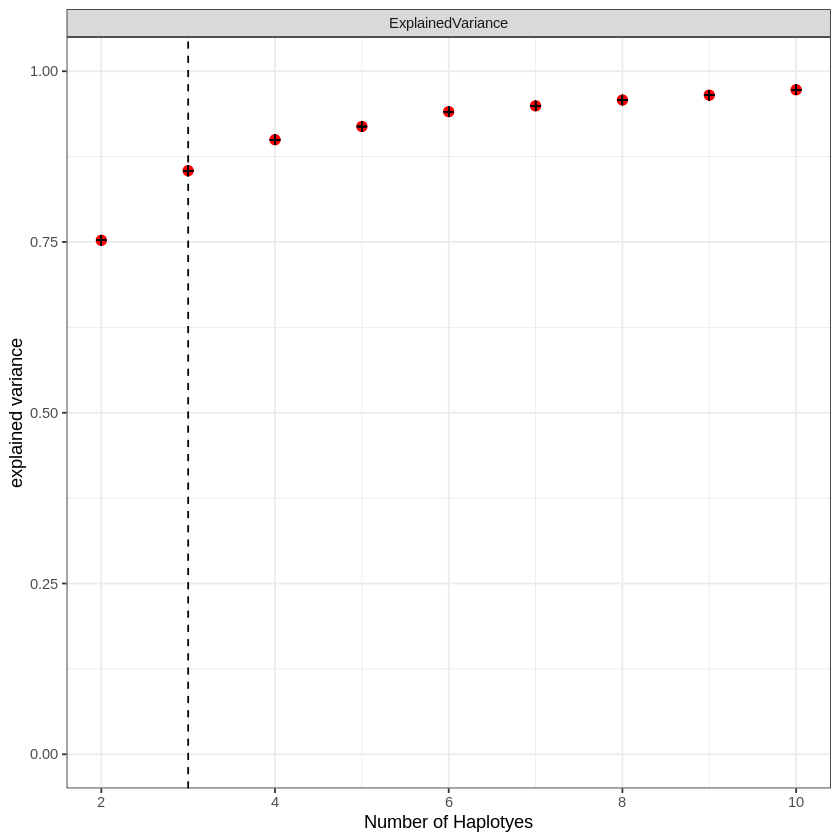

In [32]:
p <- plotNumberHaplotyes(gof)
p <- p + ylim(c(0, 1)) + geom_vline(xintercept = num, linetype = 2)
p

In [ ]:
decomposed <- findHaplotypes(data.matrix(omm), num)
contrib <- HaplotypeDeconstructor::HaplotypeEvar(decomposed)

In [ ]:
contrib$combined_variance <- NULL
contrib$day <- as.integer(substr(contrib$sample, 6,8))
contrib$mouse <- as.integer(substr(contrib$sample, 1,4))  
contrib$group <- translateMouseIdToTreatmentGroup(contrib$mouse)
s2 <- reshape2::melt(contrib, id.vars = c("sample", "day", "mouse", "group"))
set.seed(42)
palette <- randomcoloR::distinctColorPalette(num+1)
palette[1] <- "grey80"
group_order = c("Control","Ciprofloxacin",
                  "Tetracyclin", "Vancomycin")
mouse_order = c("1683","1681","1684",
                  "1688", "1686", "1690",
                  "1692", "1693", "1694",
                  "1699", "1698", "1697")
  
s2 <- arrange(transform(s2, group = factor(group,levels = group_order)), group)
s2 <- arrange(transform(s2, mouse = factor(mouse,levels = mouse_order)), mouse)

In [ ]:
p <- ggplot(s2, aes(x = day, y = value, fill = variable))
p <- p + geom_bar(size = 0, color = "black", stat = "identity",
                    position = "stack")
p <- p + xlab("time (day)") + ylab("explained variance by haplotype [%]")
p <- p + theme_bw() + theme(panel.border = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              axis.line = element_line(color = "black"))
p <- p + theme_pmuench(base_size = 9) + facet_wrap(~group + mouse, nrow = 4)
p <- p + scale_fill_manual(values = palette) 
p <- p + theme(aspect.ratio = .5, strip.background = element_blank(), strip.placement = "outside")
p <- p + theme(panel.background = element_rect(fill = "white", colour = 'black'))
p <- p + geom_vline(xintercept = c(4, 18, 53, 67), 
                      linetype = 1, color = "black", alpha = 1)
p

In [ ]:
s2 <- s2[which(s2$mouse %in% c("1683", "1688", "1692", "1699")),]
p <- ggplot(s2, aes(x = day, y = value, fill = variable))
p <- p + geom_bar(size = 0, color = "black", stat = "identity",
                    position = "stack")
p <- p + xlab("time (day)") + ylab("explained variance by haplotype [%]")
p <- p + theme_bw() + theme(panel.border = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              axis.line = element_line(color = "black"))
p <- p + theme_pmuench(base_size = 9) + facet_wrap(~group + mouse, nrow = 4)
p <- p + scale_fill_manual(values = palette) 
p <- p + theme(aspect.ratio = .5, strip.background = element_blank(), strip.placement = "outside")
p <- p + theme(panel.background = element_rect(fill = "white", colour = 'black'))
p <- p + geom_vline(xintercept = c(4, 18, 53, 67), 
                      linetype = 1, color = "black", alpha = .2)
p

pdf("nmf_amuc_1.pdf", width = 4, height = 8)
print(p)
dev.off()

## Turicimonas_muris_YL45

In [34]:
bug <- "Turicimonas_muris_YL45"
dat <- wgs_data[which(wgs_data$chr == bug), ]
dim(dat)
nrow(dat)
omm <- dat[, grep("16", colnames(dat), invert = F)]
annot  <- dat[, grep("16", colnames(dat), invert = T)]
omm[is.na(omm)] <- 0
rownames(omm) <- paste0(annot$chr, "-",annot$POS, "-", annot$REF,"-", annot$ALT)
omm <- data.matrix(omm)
omm <- omm[,colSds(omm) > 0]
gof <- assessNumberHaplotyes(omm, 2:10)
gof_agg <- aggregate(data = gof, ExplainedVariance ~NumberHaplotyes, FUN = mean)
num <- min(gof_agg[which(gof_agg$ExplainedVariance > 0.8),]$NumberHaplotyes)

[1]  45 135

[1] 45

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



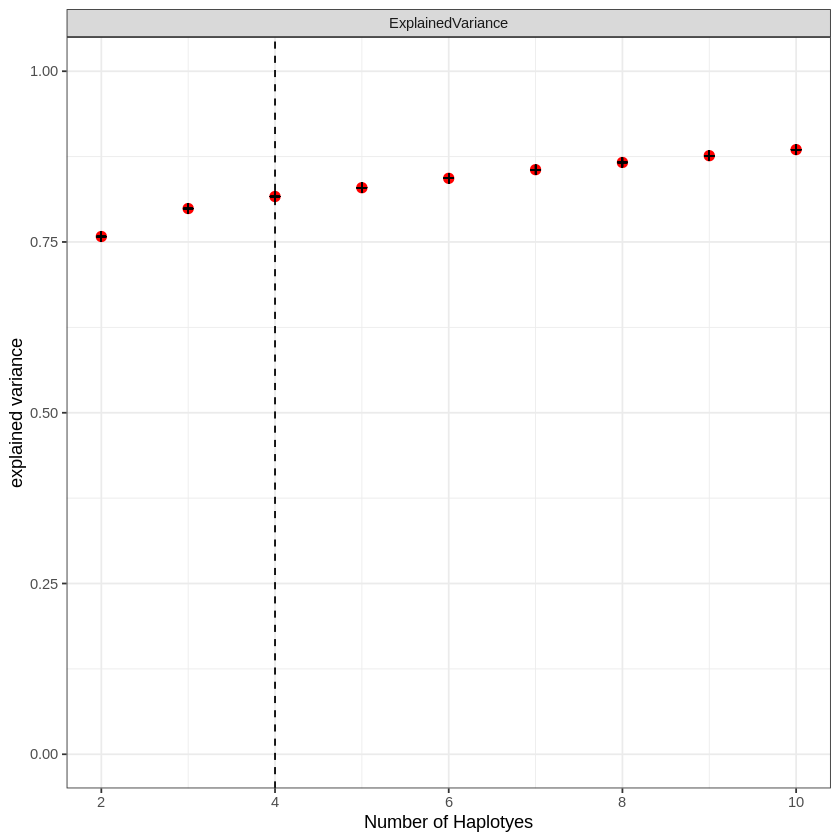

In [35]:
p <- plotNumberHaplotyes(gof)
p <- p + ylim(c(0, 1)) + geom_vline(xintercept = num, linetype = 2)
p

In [36]:
decomposed <- findHaplotypes(data.matrix(omm), num)
contrib <- HaplotypeDeconstructor::HaplotypeEvar(decomposed)

Processing Sample1

Processing Sample2

Processing Sample3

Processing Sample4

Processing Sample5

Processing Sample6

Processing Sample7

Processing Sample8

Processing Sample9

Processing Sample10

Processing Sample11

Processing Sample12

Processing Sample13

Processing Sample14

Processing Sample15

Processing Sample16

Processing Sample17

Processing Sample18

Processing Sample19

Processing Sample20

Processing Sample21

Processing Sample22

Processing Sample23

Processing Sample24

Processing Sample25

Processing Sample26

Processing Sample27

Processing Sample28

Processing Sample29

Processing Sample30

Processing Sample31

Processing Sample32

Processing Sample33

Processing Sample34

Processing Sample35

Processing Sample36

Processing Sample37

Processing Sample38

Processing Sample39

Processing Sample40

Processing Sample41

Processing Sample42

Processing Sample43

Processing Sample44

Processing Sample45

Processing Sample46

Processing Sample47

Processing Sample48

P

In [37]:
contrib$combined_variance <- NULL
contrib$day <- as.integer(substr(contrib$sample, 6,8))
contrib$mouse <- as.integer(substr(contrib$sample, 1,4))  
contrib$group <- translateMouseIdToTreatmentGroup(contrib$mouse)
s2 <- reshape2::melt(contrib, id.vars = c("sample", "day", "mouse", "group"))
set.seed(42)
palette <- randomcoloR::distinctColorPalette(num+1)
palette[1] <- "grey80"
group_order = c("Control","Ciprofloxacin",
                  "Tetracyclin", "Vancomycin")
mouse_order = c("1683","1681","1684",
                  "1688", "1686", "1690",
                  "1692", "1693", "1694",
                  "1699", "1698", "1697")
  
s2 <- arrange(transform(s2, group = factor(group,levels = group_order)), group)
s2 <- arrange(transform(s2, mouse = factor(mouse,levels = mouse_order)), mouse)

Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


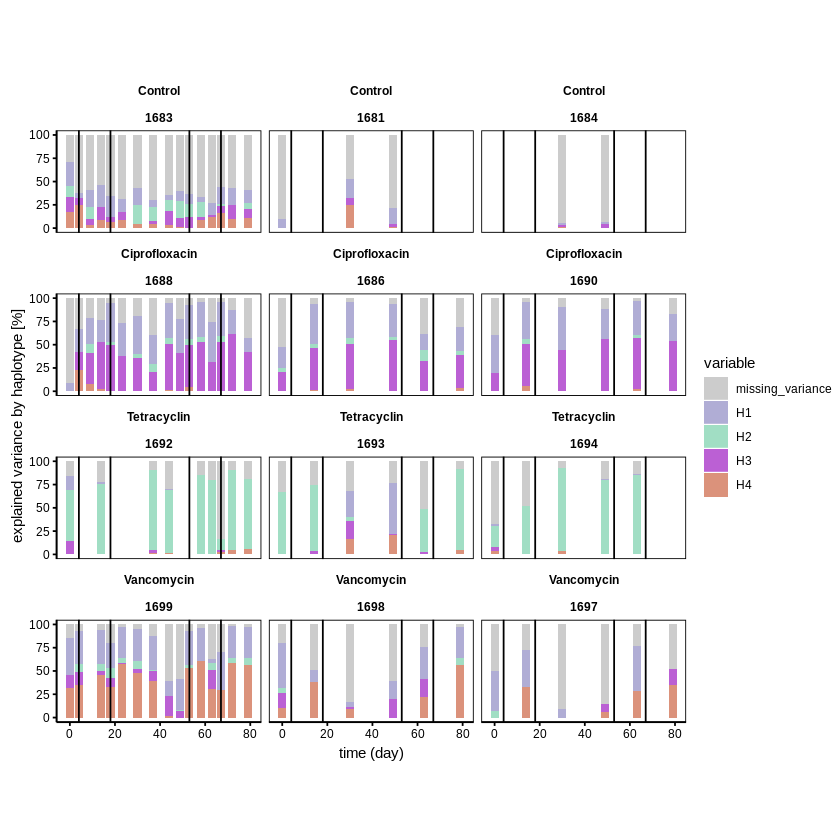

In [38]:
p <- ggplot(s2, aes(x = day, y = value, fill = variable))
p <- p + geom_bar(size = 0, color = "black", stat = "identity",
                    position = "stack")
p <- p + xlab("time (day)") + ylab("explained variance by haplotype [%]")
p <- p + theme_bw() + theme(panel.border = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              axis.line = element_line(color = "black"))
p <- p + theme_pmuench(base_size = 9) + facet_wrap(~group + mouse, nrow = 4)
p <- p + scale_fill_manual(values = palette) 
p <- p + theme(aspect.ratio = .5, strip.background = element_blank(), strip.placement = "outside")
p <- p + theme(panel.background = element_rect(fill = "white", colour = 'black'))
p <- p + geom_vline(xintercept = c(4, 18, 53, 67), 
                      linetype = 1, color = "black", alpha = 1)
p

Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


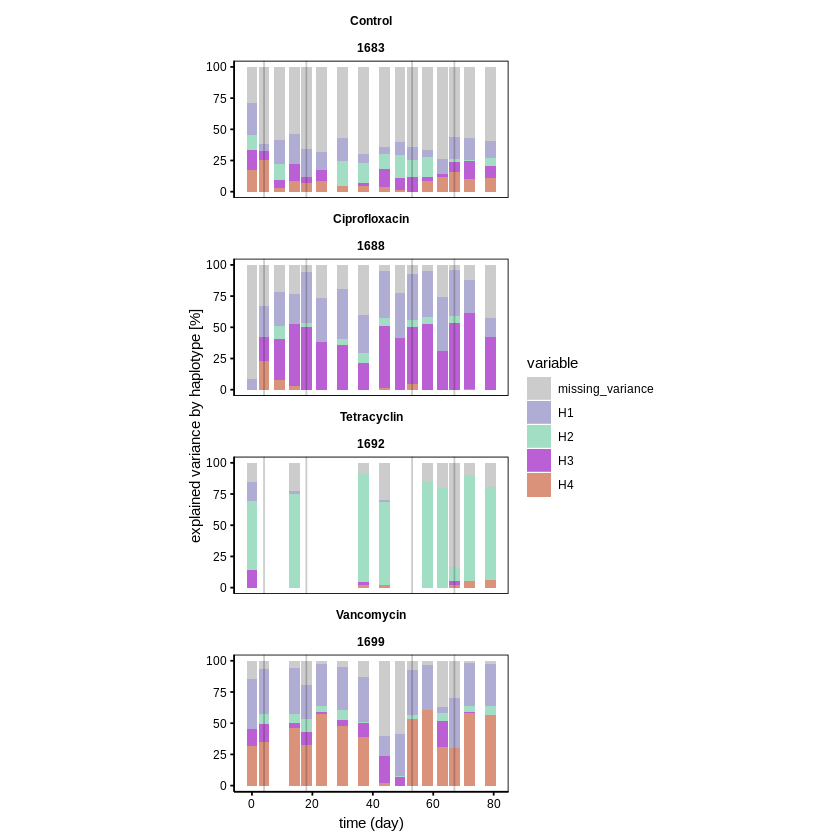

In [40]:
s2 <- s2[which(s2$mouse %in% c("1683", "1688", "1692", "1699")),]
p <- ggplot(s2, aes(x = day, y = value, fill = variable))
p <- p + geom_bar(size = 0, color = "black", stat = "identity",
                    position = "stack")
p <- p + xlab("time (day)") + ylab("explained variance by haplotype [%]")
p <- p + theme_bw() + theme(panel.border = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              axis.line = element_line(color = "black"))
p <- p + theme_pmuench(base_size = 9) + facet_wrap(~group + mouse, nrow = 4)
p <- p + scale_fill_manual(values = palette) 
p <- p + theme(aspect.ratio = .5, strip.background = element_blank(), strip.placement = "outside")
p <- p + theme(panel.background = element_rect(fill = "white", colour = 'black'))
p <- p + geom_vline(xintercept = c(4, 18, 53, 67), 
                      linetype = 1, color = "black", alpha = .2)
p

In [41]:
pdf("Figure_5_c.pdf", width = 4, height = 8)
print(p)
dev.off()

png 
  2

## Muribaculum intestinale YL27

In [42]:
bug <- "Muribaculum_intestinale_YL27"
dat <- wgs_data[which(wgs_data$chr == bug), ]
dim(dat)
nrow(dat)
omm <- dat[, grep("16", colnames(dat), invert = F)]
annot  <- dat[, grep("16", colnames(dat), invert = T)]
omm[is.na(omm)] <- 0
rownames(omm) <- paste0(annot$chr, "-",annot$POS, "-", annot$REF,"-", annot$ALT)
omm <- data.matrix(omm)
omm <- omm[,colSds(omm) > 0]
gof <- assessNumberHaplotyes(omm, 2:10)
gof_agg <- aggregate(data = gof, ExplainedVariance ~NumberHaplotyes, FUN = mean)
num <- min(gof_agg[which(gof_agg$ExplainedVariance > 0.8),]$NumberHaplotyes)

[1]  39 135

[1] 39

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



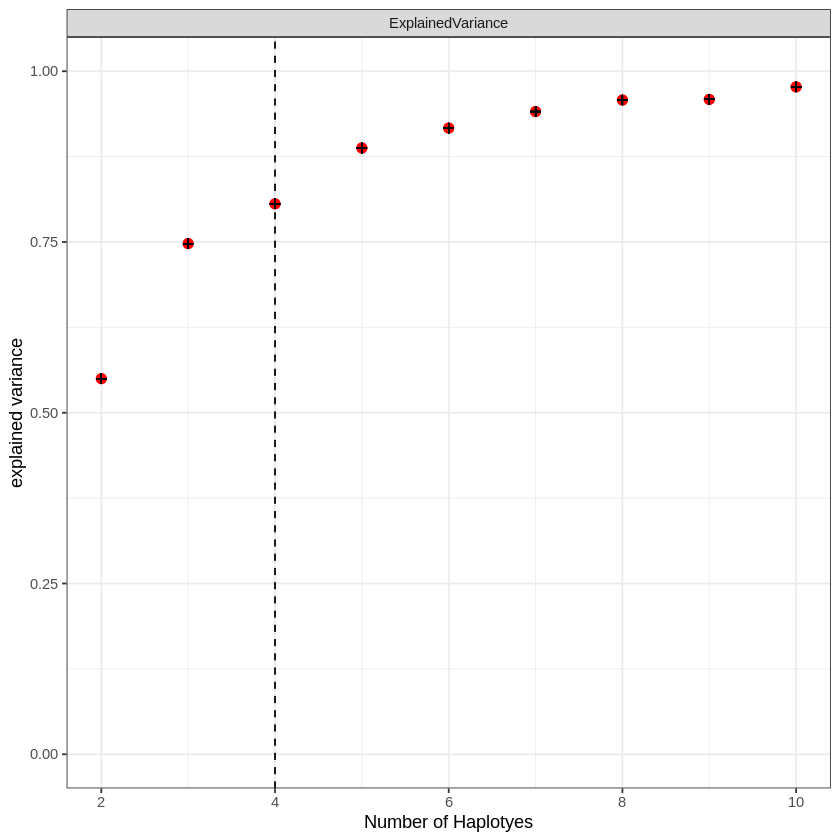

In [43]:
p <- plotNumberHaplotyes(gof)
p <- p + ylim(c(0, 1)) + geom_vline(xintercept = num, linetype = 2)
p

In [44]:
decomposed <- findHaplotypes(data.matrix(omm), num)
contrib <- HaplotypeDeconstructor::HaplotypeEvar(decomposed)

Processing Sample1

Processing Sample2

Processing Sample3

Processing Sample4

Processing Sample5

Processing Sample6

Processing Sample7

Processing Sample8

Processing Sample9

Processing Sample10

Processing Sample11

Processing Sample12

Processing Sample13

Processing Sample14

Processing Sample15

Processing Sample16

Processing Sample17

Processing Sample18

Processing Sample19

Processing Sample20

Processing Sample21

Processing Sample22

Processing Sample23

Processing Sample24

Processing Sample25

Processing Sample26

Processing Sample27

Processing Sample28

Processing Sample29

Processing Sample30

Processing Sample31

Processing Sample32

Processing Sample33

Processing Sample34

Processing Sample35

Processing Sample36

Processing Sample37

Processing Sample38

Processing Sample39

Processing Sample40

Processing Sample41

Processing Sample42

Processing Sample43

Processing Sample44

Processing Sample45

Processing Sample46

Processing Sample47

Processing Sample48

P

In [45]:
contrib$combined_variance <- NULL
contrib$day <- as.integer(substr(contrib$sample, 6,8))
contrib$mouse <- as.integer(substr(contrib$sample, 1,4))  
contrib$group <- translateMouseIdToTreatmentGroup(contrib$mouse)
s2 <- reshape2::melt(contrib, id.vars = c("sample", "day", "mouse", "group"))
set.seed(42)
palette <- randomcoloR::distinctColorPalette(num+1)
palette[1] <- "grey80"
group_order = c("Control","Ciprofloxacin",
                  "Tetracyclin", "Vancomycin")
mouse_order = c("1683","1681","1684",
                  "1688", "1686", "1690",
                  "1692", "1693", "1694",
                  "1699", "1698", "1697")
  
s2 <- arrange(transform(s2, group = factor(group,levels = group_order)), group)
s2 <- arrange(transform(s2, mouse = factor(mouse,levels = mouse_order)), mouse)

Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


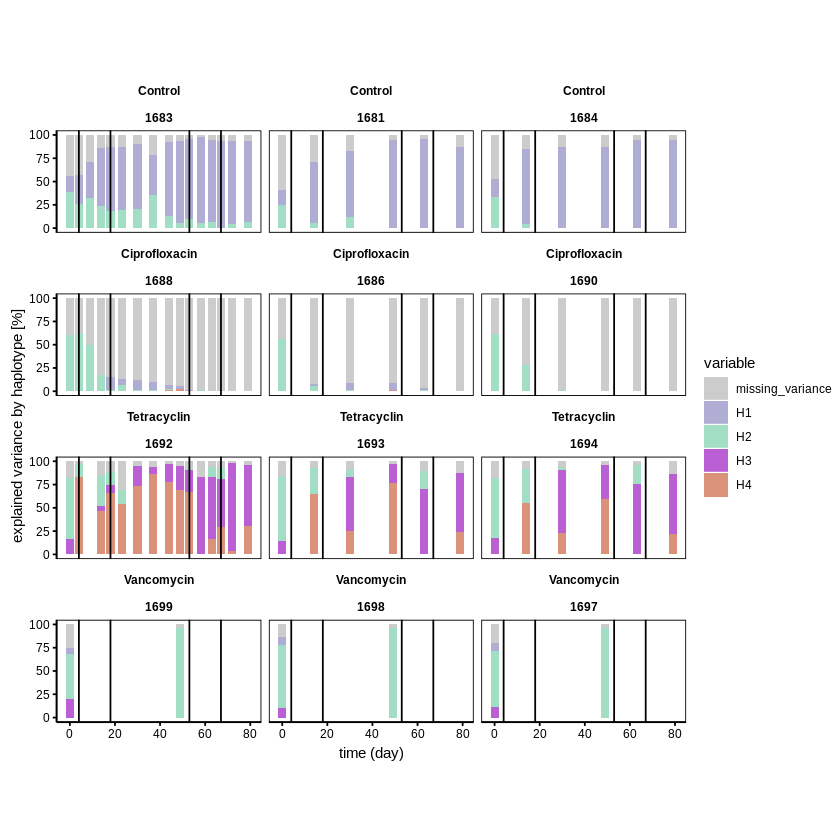

In [22]:
p <- ggplot(s2, aes(x = day, y = value, fill = variable))
p <- p + geom_bar(size = 0, color = "black", stat = "identity",
                    position = "stack")
p <- p + xlab("time (day)") + ylab("explained variance by haplotype [%]")
p <- p + theme_bw() + theme(panel.border = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              axis.line = element_line(color = "black"))
p <- p + theme_pmuench(base_size = 9) + facet_wrap(~group + mouse, nrow = 4)
p <- p + scale_fill_manual(values = palette) 
p <- p + theme(aspect.ratio = .5, strip.background = element_blank(), strip.placement = "outside")
p <- p + theme(panel.background = element_rect(fill = "white", colour = 'black'))
p <- p + geom_vline(xintercept = c(4, 18, 53, 67), 
                      linetype = 1, color = "black", alpha = 1)
p

Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


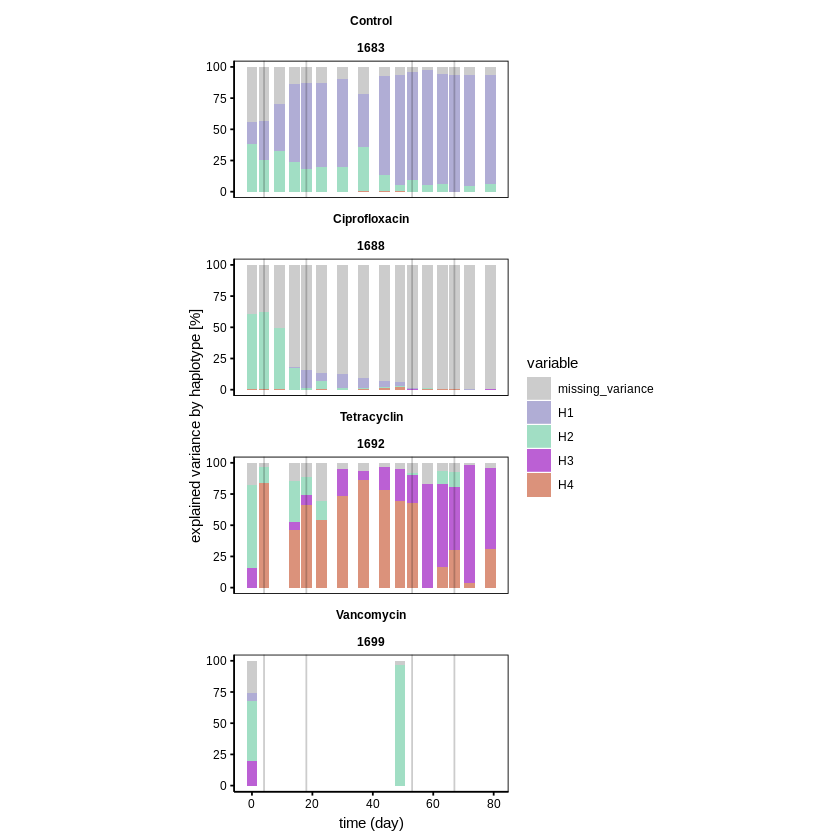

In [23]:
s2 <- s2[which(s2$mouse %in% c("1683", "1688", "1692", "1699")),]
p <- ggplot(s2, aes(x = day, y = value, fill = variable))
p <- p + geom_bar(size = 0, color = "black", stat = "identity",
                    position = "stack")
p <- p + xlab("time (day)") + ylab("explained variance by haplotype [%]")
p <- p + theme_bw() + theme(panel.border = element_blank(),
                              panel.grid.major = element_blank(),
                              panel.grid.minor = element_blank(),
                              axis.line = element_line(color = "black"))
p <- p + theme_pmuench(base_size = 9) + facet_wrap(~group + mouse, nrow = 4)
p <- p + scale_fill_manual(values = palette) 
p <- p + theme(aspect.ratio = .5, strip.background = element_blank(), strip.placement = "outside")
p <- p + theme(panel.background = element_rect(fill = "white", colour = 'black'))
p <- p + geom_vline(xintercept = c(4, 18, 53, 67), 
                      linetype = 1, color = "black", alpha = .2)
p

In [24]:
pdf("Figure_5_b.pdf", width = 4, height = 8)
print(p)
dev.off()

png 
  2